**Import packages**

In [1]:
dataset_folder = ""
filters = 64
epochs = 60
batch_size = 128
protein_len = 200
protein_family_number = 600

In [2]:
import tensorflow as tf
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import add, maximum, minimum
from keras import regularizers
import pandas as pd
import numpy as np
import os

2023-12-14 21:27:05.623941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 21:27:05.655042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 21:27:05.655071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 21:27:05.655090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 21:27:05.660437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 21:27:05.660824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
def read_data(name_sub_folder):
  full_data = []
  for f in os.listdir(os.path.join(dataset_folder, name_sub_folder)):
    data = pd.read_csv(os.path.join(dataset_folder, name_sub_folder, f))
    full_data.append(data)
  return pd.concat(full_data)

In [4]:
dataset_train = read_data("train")
dataset_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [5]:
dataset_test = read_data("test")
dataset_test.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGR..REVMAD....ACLQGMM..GCVYG..........TAG...,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGK.PVSRRTAAASATVLLG.EK..........AFWLV.......,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGT.C...D..VA...ME..AR.NQ.......T....G......,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKV..G.................KEYQLLN....CD...,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTD...............AMVVSSYLN..TDKSLV...,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...


In [6]:
dataset_dev = read_data("dev")
dataset_dev.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,zf-Tim10_DDP,N1QB11_PSEFD/15-76,PF02953.15,..RMEKKQMKDFMNMYSNLVQRCFNDCV...........TD.F......,RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...
1,DNA_primase_S,A8XA78_CAEBR/105-345,PF01896.19,FDID..LTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFG...,FDIDLTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFGFN...
2,Col_cuticle_N,A8XBM5_CAEBR/9-56,PF01484.17,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIA...,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIAWD
3,GST_C_3,W4XBU3_STRPU/120-207,PF14497.6,KD.................................KLKESLPKTVN...,KDKLKESLPKTVNPILLKFLEKALEDNPNGNGYFVGQDATMVEFVY...
4,Ada_Zn_binding,E8U5K2_DEIML/9-73,PF02805.16,DRWQAVVQRE...AAQ.DG...LFLYAVRTTGIYCRPSCPSRRPR....,DRWQAVVQREAAQDGLFLYAVRTTGIYCRPSCPSRRPRRENVTFFE...


In [7]:
dataset_train = pd.concat([dataset_train, dataset_test])

In [8]:
dataset_train['family_accession'].value_counts()

family_accession
PF13649.6     4091
PF00560.33    2167
PF13508.7     1980
PF06580.13    1729
PF02397.16    1718
              ... 
PF10870.8        1
PF17582.2        1
PF13067.6        1
PF17590.2        1
PF12383.8        1
Name: count, Length: 17929, dtype: int64

In [9]:
classes = dataset_train['family_accession'].value_counts()[:protein_family_number].index

In [10]:
def return_from_dataset(dataset, classes):
  return [dataset.loc[dataset['family_accession'].isin(classes)].reset_index(), classes]

In [11]:
[dataset_train, classes] = return_from_dataset(dataset_train, classes) 
[dataset_dev, classes_dev] = return_from_dataset(dataset_dev, classes) 

In [12]:
dataset_train.head()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,8,His_kinase,Q47E94_DECAR/372-450,PF06580.13,SE.I..KLLHAQVNPHFLFNALNTL......S....AV...I.......,SEIKLLHAQVNPHFLFNALNTLSAVIRRDPEKACHLVLNLSTFFRK...
1,9,Porphobil_deam,HEM3_METCA/18-226,PF01379.20,LRIATRKSPLALWQAEYVASRL...........................,LRIATRKSPLALWQAEYVASRLRAAHPDLRVELVGMTTRGDKLLDA...
2,21,Tyr_Deacylase,R5QV78_9FIRM/2-144,PF02580.16,KFVIQRVNHASVCV.........................DG...TT...,KFVIQRVNHASVCVDGTTVGAIEKGLLVLIGVGKQDTKEIADKYLQ...
3,26,PHO4,G2MLF6_9EURY/25-387,PF01384.20,.GANSNSPPFAPAIGANAVSTMRAA.FLIGLLAALGA............,GANSNSPPFAPAIGANAVSTMRAAFLIGLLAALGALTQGGSISETV...
4,27,ILVD_EDD,Q0AT03_MARMM/37-548,PF00920.21,KPMIGVINTWTTVTPC..........NMHLAD.LAAPVREAVREAG...,KPMIGVINTWTTVTPCNMHLADLAAPVREAVREAGGHPVDFNTIVV...


In [13]:
print(classes)
print(len(classes))

Index(['PF13649.6', 'PF00560.33', 'PF13508.7', 'PF06580.13', 'PF02397.16',
       'PF00677.17', 'PF01035.20', 'PF02417.15', 'PF13472.6', 'PF00684.19',
       ...
       'PF00681.20', 'PF02570.15', 'PF00813.20', 'PF01176.19', 'PF00447.17',
       'PF12392.8', 'PF07963.12', 'PF00338.22', 'PF00858.24', 'PF02595.15'],
      dtype='object', name='family_accession', length=600)
600


In [14]:
def features_target_split(dataset):
  return [dataset['sequence'], dataset['family_accession']]

In [15]:
[features, target] = features_target_split(dataset_train)
[features_dev, target_dev] = features_target_split(dataset_dev)

In [16]:
features.head()

0    SEIKLLHAQVNPHFLFNALNTLSAVIRRDPEKACHLVLNLSTFFRK...
1    LRIATRKSPLALWQAEYVASRLRAAHPDLRVELVGMTTRGDKLLDA...
2    KFVIQRVNHASVCVDGTTVGAIEKGLLVLIGVGKQDTKEIADKYLQ...
3    GANSNSPPFAPAIGANAVSTMRAAFLIGLLAALGALTQGGSISETV...
4    KPMIGVINTWTTVTPCNMHLADLAAPVREAVREAGGHPVDFNTIVV...
Name: sequence, dtype: object

In [17]:
target.head()

0    PF06580.13
1    PF01379.20
2    PF02580.16
3    PF01384.20
4    PF00920.21
Name: family_accession, dtype: object

**Preprocessing**

In [18]:
def cut_protein_sequence(sequence):
  return sequence.apply(lambda seq: [seq[i:i+ 1] for i in range(0, len(seq), 1)])

In [19]:
features = cut_protein_sequence(features)
features_dev = cut_protein_sequence(features_dev)

In [20]:
features.head()

0    [S, E, I, K, L, L, H, A, Q, V, N, P, H, F, L, ...
1    [L, R, I, A, T, R, K, S, P, L, A, L, W, Q, A, ...
2    [K, F, V, I, Q, R, V, N, H, A, S, V, C, V, D, ...
3    [G, A, N, S, N, S, P, P, F, A, P, A, I, G, A, ...
4    [K, P, M, I, G, V, I, N, T, W, T, T, V, T, P, ...
Name: sequence, dtype: object

In [21]:
label_ = preprocessing.LabelEncoder()
label_.fit(target)

LabelEncoder()

In [22]:
label_.classes_

array(['PF00003.22', 'PF00006.25', 'PF00013.29', 'PF00020.18',
       'PF00023.30', 'PF00036.32', 'PF00037.27', 'PF00080.20',
       'PF00095.21', 'PF00100.23', 'PF00115.20', 'PF00119.20',
       'PF00126.27', 'PF00137.21', 'PF00140.20', 'PF00146.21',
       'PF00162.19', 'PF00163.19', 'PF00174.19', 'PF00177.21',
       'PF00200.23', 'PF00221.19', 'PF00231.19', 'PF00237.19',
       'PF00241.20', 'PF00252.18', 'PF00271.31', 'PF00276.20',
       'PF00278.22', 'PF00281.19', 'PF00285.21', 'PF00288.26',
       'PF00298.19', 'PF00303.19', 'PF00312.22', 'PF00318.20',
       'PF00327.20', 'PF00329.19', 'PF00330.20', 'PF00333.20',
       'PF00338.22', 'PF00343.20', 'PF00344.20', 'PF00348.17',
       'PF00349.21', 'PF00358.20', 'PF00365.20', 'PF00366.20',
       'PF00367.20', 'PF00380.19', 'PF00381.19', 'PF00391.23',
       'PF00397.26', 'PF00400.32', 'PF00410.19', 'PF00433.24',
       'PF00438.20', 'PF00447.17', 'PF00453.18', 'PF00471.20',
       'PF00472.20', 'PF00475.18', 'PF00476.20', 'PF004

In [23]:
target = label_.transform(target)
target_dev = label_.transform(target_dev)

In [24]:
target[0:10]

array([440, 169, 275, 170, 112, 242, 153, 439, 566, 320])

In [25]:
target = tf.keras.utils.to_categorical(target)
target_dev = tf.keras.utils.to_categorical(target_dev)

In [26]:
tokenizer_seq=  Tokenizer(num_words = 2000)
tokenizer_seq.fit_on_texts(features)

In [27]:
features = tokenizer_seq.texts_to_sequences(features)
features_dev = tokenizer_seq.texts_to_sequences(features_dev)

In [28]:
print(len(features[0]))
print(len(features))
features[0][:10]

79
370652


[7, 6, 5, 11, 1, 1, 18, 2, 15, 4]

In [29]:
# compute max_len

max_len = 0

for i in range(len(features)):
    if len(features[i]) > max_len:
        max_len = len(features[i])

print(max_len)

1182


In [30]:
features = pad_sequences(features, maxlen = 200, padding = "post", truncating = "post")
features.shape

(370652, 200)

In [31]:
features[0:10]

array([[ 7,  6,  5, ...,  0,  0,  0],
       [ 1,  8,  5, ...,  4,  6, 19],
       [11, 13,  4, ...,  0,  0,  0],
       ...,
       [ 2, 16, 13, ...,  0,  0,  0],
       [ 9, 13,  1, ...,  0,  0,  0],
       [ 4,  4,  4, ...,  7,  1, 14]], dtype=int32)

In [32]:
features_dev = pad_sequences(features_dev, maxlen = features.shape[1], padding = "post", truncating = "post")

In [33]:
print(tokenizer_seq.word_index)

{'l': 1, 'a': 2, 'g': 3, 'v': 4, 'i': 5, 'e': 6, 's': 7, 'r': 8, 'd': 9, 't': 10, 'k': 11, 'p': 12, 'f': 13, 'n': 14, 'q': 15, 'y': 16, 'm': 17, 'h': 18, 'c': 19, 'w': 20, 'x': 21, 'u': 22, 'b': 23}


In [34]:
vocabulary = len(tokenizer_seq.word_index)
vocabulary

23

**CNN MODEL**

In [35]:
def resnet_con(inputs, filters, activation = "relu", strides = 1):
  x = tf.keras.layers.BatchNormalization()(inputs)
  x = tf.keras.layers.Conv1D(filters, 3, strides = strides, activation = activation, padding = "same",
                             kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
  x = tf.keras.layers.Activation("relu")(x)
  return x

In [36]:
filters = 64
input = tf.keras.layers.Input(shape=(features.shape[1], ))
x = tf.keras.layers.Embedding(vocabulary + 1, 150)(input)
x1 = tf.keras.layers.AveragePooling1D()(x)
x2 = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.concatenate([x1, x2])
x = tf.keras.layers.Dropout(0.3)(x)
x = resnet_con(x, filters)
for stack in range(2):
  for block in range(3):
    strides = 1
    if stack > 0 and block == 0:
      strides = 2
    y = resnet_con(x, filters, activation = None, strides = strides)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv1D(filters, 3, activation = None, padding = "same",
                               kernel_regularizer=tf.keras.regularizers.L2(0.01))(y)                       
    if stack > 0 and block == 0:
      strides = 2
      x = tf.keras.layers.Conv1D(filters , 1, activation = None, strides = strides, padding = "same",
                                 kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = add([x, y])
    x = tf.keras.layers.Activation("relu")(x)
  filters *=2
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(1024, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.45)(x)
y = tf.keras.layers.Dense(len(classes), activation ="softmax",
                          kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
m = tf.keras.models.Model(input, y)
m.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), loss = "categorical_crossentropy", metrics = ['accuracy'])
m.summary() 

2023-12-14 21:30:01.411916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 21:30:01.429885: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 150)             3600      ['input_1[0][0]']             
                                                                                                  
 average_pooling1d (Average  (None, 100, 150)             0         ['embedding[0][0]']           
 Pooling1D)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 100, 150)             0         ['embedding[0][0]']       

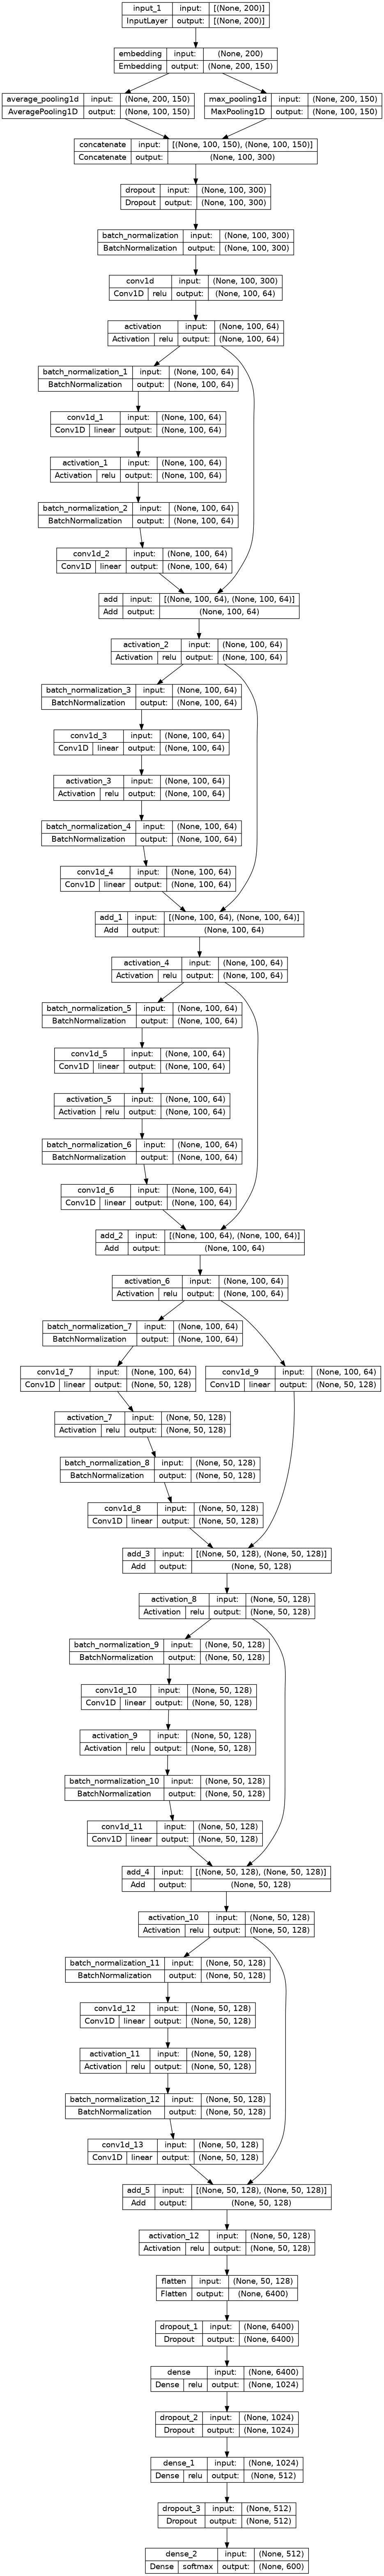

In [37]:
tf.keras.utils.plot_model(m, show_shapes = True, show_layer_activations= True)